In [8]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import notebook_utils as nu
import importlib
importlib.reload(nu)
importlib.reload(sc)
sc.settings.verbosity = 0

# Filtering and inspecting scRNA counts

This notebook contains 3 sections used to prepare a scRNA-count data for use in training scRNA denoising neural networks

* Inspecting data distributions and filtering counts

* Selecting the top n most variable genes

* Creating a fasta file with tss-sequences for the relevant genes

## Loading, inspecting and filtering counts

First we load the data into a anndata object using the scanpy.

In [9]:
#Read in the data in a anndata format and calculate some useful metrics
scRNA_counts = sc.read_10x_mtx('./../../data/10xPBMC/',
                       var_names='gene_ids',
                       cache=True);
scRNA_counts.var_names_make_unique();


sc.pp.calculate_qc_metrics(scRNA_counts, 
                           percent_top=None,
                           inplace=True, 
                           log1p=False)
print(f'The count matrix consists of {scRNA_counts.n_obs} cells and {scRNA_counts.n_vars} genes')
print(f'And is {((1-scRNA_counts.X.count_nonzero()/(scRNA_counts.n_vars*scRNA_counts.n_obs))*100):.2f}% Sparse')

The count matrix consists of 10985 cells and 36601 genes
And is 92.92% Sparse


The count matrix is extremely sparse. Furthermore the dataset still most likely includes many cells of bad quality, which would be best to remove. Below code-cells helps visualize data distributions and chose cutoff for filtering the dataset.

**Library size**

Library size is indicative of bad quality cells/sequencing. For example few overall counts is indicative of cell-less droplets while a large library size is indicative of multicell droplets.

Below cell can be used to inspect the distribution of library sizes in the dataset.

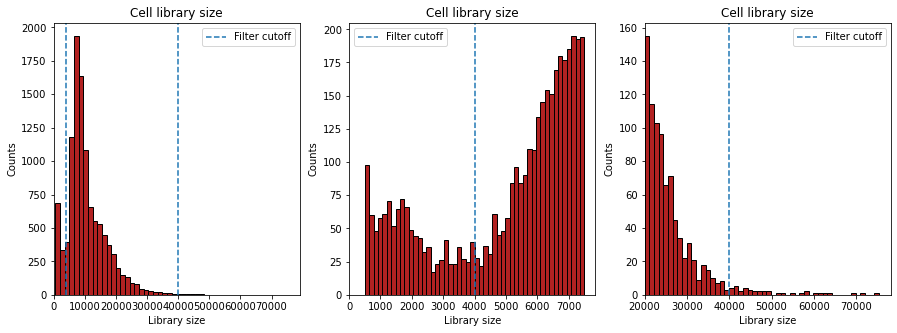

In [10]:
%matplotlib inline
#Plot total counts per cell


#plot 2:
plt.figure(figsize = (15,5))
plt.subplot(1, 3, 1)
#adata.obs['n_counts'][adata.obs['n_counts']<4000]
nu.plot_histo_filter(scRNA_counts.obs.total_counts,
                  title='Cell library size',
                  xlab='Library size',
                  ylab='Counts',
                    cutoff_points=[4000,40000],
                  bins=50);
#Peaks below 4000 uninformative given rest of distribution probably cell debris
plt.subplot(1, 3, 2)
nu.plot_histo_filter(scRNA_counts.obs.total_counts[scRNA_counts.obs.total_counts<7500],
                  cutoff_points=[4000],
                  title='Cell library size',
                  xlab='Library size',
                  ylab='Counts',
                  bins=50);

plt.subplot(1, 3, 3)
nu.plot_histo_filter(scRNA_counts.obs.total_counts[scRNA_counts.obs.total_counts>20000],
                  cutoff_points=[40000],
                  title='Cell library size',
                  xlab='Library size',
                  ylab='Counts',
                  bins=50,
                    xbot=20000);


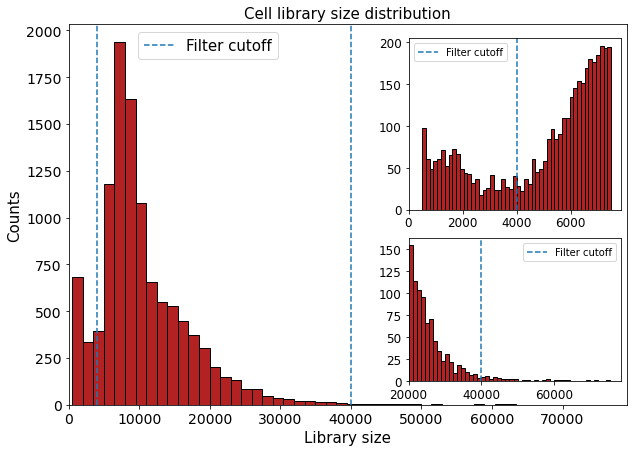

In [23]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


fig, ax1 = plt.subplots(figsize=[10, 7])
nu.plot_histo_filter(scRNA_counts.obs.total_counts,
                  title='Cell library size distribution',
                  xlab='Library size',
                  ylab='Counts',
                  cutoff_points=[4000,40000],
                  bins=50);
plt.xlabel('Library size', fontsize=15)
plt.title('Cell library size distribution', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.legend(bbox_to_anchor=(0.25, 1), loc='upper center', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.add_subplot(111)


# We use the axes transform as bbox_transform. Therefore the bounding box
# needs to be specified in axes coordinates ((0, 0) is the lower left corner
# of the axes, (1, 1) is the upper right corner).
# The bounding box (.2, .4, .6, .5) starts at (.2, .4) and ranges to (.8, .9)
# in those coordinates.
# Inside of this bounding box an inset of half the bounding box' width and
# three quarters of the bounding box' height is created. The lower left corner
# of the inset is aligned to the lower left corner of the bounding box (loc=3).
# The inset is then offset by the default 0.5 in units of the font size.

ax2 = inset_axes(ax1, width="40%", height="50%",
                   bbox_to_anchor=(.6, .50, .95, .9),
                   bbox_transform=ax1.transAxes, loc=3)

nu.plot_histo_filter(scRNA_counts.obs.total_counts[scRNA_counts.obs.total_counts<7500],
                  cutoff_points=[4000],
                  title='',
                  xlab='',
                  ylab='',
                  bins=50);
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax3 = inset_axes(ax1, width="40%", height="75%",
                   bbox_to_anchor=(.6, .05, .95, .5),
                   bbox_transform=ax1.transAxes, loc=3)

nu.plot_histo_filter(scRNA_counts.obs.total_counts[scRNA_counts.obs.total_counts>20000],
                  cutoff_points=[40000],
                  title='',
                  xlab='',
                  ylab='',
                  bins=50,
                  xbot=20000);
plt.locator_params(axis='x', nbins=4)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# We set the axis limits to something other than the default, in order to not
# distract from the fact that axes coordinates are used here.


plt.savefig('/home/jbs/scRNA-seq/steps/redone/Figures/library_cutoff.svg', format='svg') 
plt.show()


**Gene expression per cell**

Abnormally many or few genes expressed per cell may again be indicative of cell-less droplets or multicell droplets.

Below cell visualizes the distribution of the number of genes expressed per cell. 

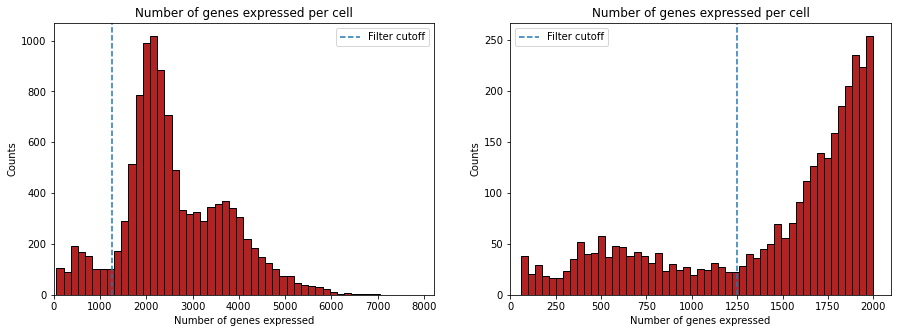

In [13]:
%matplotlib inline
#plot 2:
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
#adata.obs['n_counts'][adata.obs['n_counts']<4000]
#Plot total counts per cell
nu.plot_histo_filter(scRNA_counts.obs.n_genes_by_counts,
                  cutoff_points=[1250],
                  title='Number of genes expressed per cell',
                  xlab='Number of genes expressed',
                  ylab='Counts',
                  bins=50);

plt.subplot(1, 2, 2)
nu.plot_histo_filter(scRNA_counts.obs.n_genes_by_counts[scRNA_counts.obs.n_genes_by_counts<2000],
                  cutoff_points=[1250],
                  title='Number of genes expressed per cell',
                  xlab='Number of genes expressed',
                  ylab='Counts',
                  bins=50);



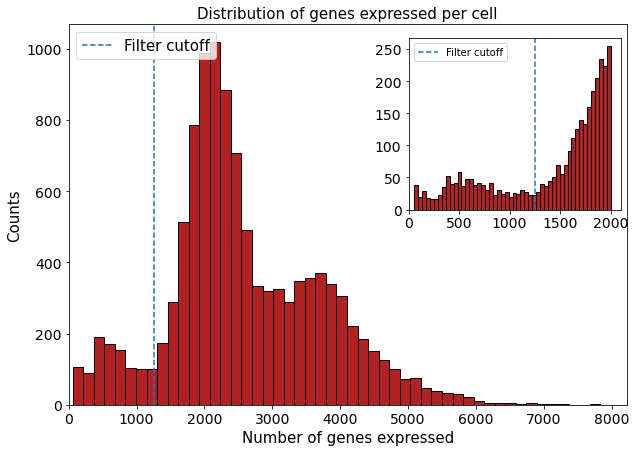

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax1 = plt.subplots(figsize=[10, 7])
nu.plot_histo_filter(scRNA_counts.obs.n_genes_by_counts,
                  cutoff_points=[1250],
                  title='Distribution of genes expressed per cell',
                  xlab='Number of genes expressed',
                  ylab='Counts',
                  bins=50);
plt.xlabel('Number of genes expressed', fontsize=15)
plt.title('Distribution of genes expressed per cell', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.legend(loc='upper left', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.add_subplot(111)


# We use the axes transform as bbox_transform. Therefore the bounding box
# needs to be specified in axes coordinates ((0, 0) is the lower left corner
# of the axes, (1, 1) is the upper right corner).
# The bounding box (.2, .4, .6, .5) starts at (.2, .4) and ranges to (.8, .9)
# in those coordinates.
# Inside of this bounding box an inset of half the bounding box' width and
# three quarters of the bounding box' height is created. The lower left corner
# of the inset is aligned to the lower left corner of the bounding box (loc=3).
# The inset is then offset by the default 0.5 in units of the font size.

ax2 = inset_axes(ax1, width="40%", height="50%",
                   bbox_to_anchor=(.6, .50, .95, .9),
                   bbox_transform=ax1.transAxes, loc=3)

nu.plot_histo_filter(scRNA_counts.obs.n_genes_by_counts[scRNA_counts.obs.n_genes_by_counts<2000],
                  cutoff_points=[1250],
                  title='',
                  xlab='',
                  ylab='',
                  bins=50);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# We set the axis limits to something other than the default, in order to not
# distract from the fact that axes coordinates are used here.
#ax.set(xlim=(0, 10), ylim=(0, 10))


plt.savefig('/home/jbs/scRNA-seq/steps/redone/Figures/gene_cutoff.svg', format='svg') 
plt.show()


**Gene expression per gene**

Some genes are expressed very few cells and are not that interesting to look at. 

Below cell visualizes the distribution of the number of cells expressing a certain gene, showing that many of the genes in the dataset are not expressed in even 1 cell.

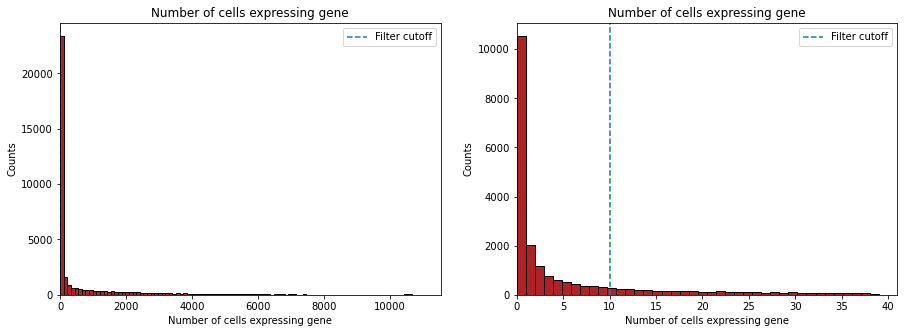

In [7]:
%matplotlib inline
#Plot distribution of number of cells expressing each gene
#plot 2:
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
#adata.obs['n_counts'][adata.obs['n_counts']<4000]
#Plot total counts per cell
nu.plot_histo_filter(scRNA_counts.var.n_cells_by_counts,
                  cutoff_points=[10],
                  title='Number of cells expressing gene',
                  xlab='Number of cells expressing gene',
                  ylab='Counts',
                  bins=100,
                  ylog=False); #xwin sets the range of x for making the hist

plt.subplot(1, 2, 2)
nu.plot_histo_filter(scRNA_counts.var.n_cells_by_counts[scRNA_counts.var.n_cells_by_counts<40],
                  cutoff_points=[10],
                  title='Number of cells expressing gene',
                  xlab='Number of cells expressing gene',
                  ylab='Counts',
                  bins=40,
                  ylog=False); #xwin sets the range of x for making the hist



**Mitochondrial content**

High amounts of mitochondrial genes expressed may be indicative of a apoptotic cell and should be filtered out. 

In [9]:
#Locate mitochondiral genes, and calculate relevant qc-metrics
scRNA_counts.var['mt'] = scRNA_counts.var['gene_symbols'].str.startswith('MT-') #Annotate mitochondrial genes
sc.pp.calculate_qc_metrics(scRNA_counts, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

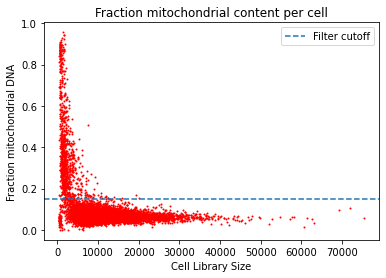

In [10]:
%matplotlib inline
nu.plot_scatter_filter(x=scRNA_counts.obs.total_counts,
                    y=scRNA_counts.obs.pct_counts_mt/100,
                    save_path_svg=None,
                    title='Fraction mitochondrial content per cell',
                    xlab='Cell Library Size',
                    ylab='Fraction mitochondrial DNA',
                    cutoff_x=[], 
                    cutoff_y=[0.15]);
plt.savefig('/home/jbs/scRNA-seq/steps/redone/Figures/mito_filter.svg', format='svg') 

In [11]:
#Filter cells with high mitochondrial content
mito_fraction_cutoff = 0.15
scRNA_counts_mitocut = scRNA_counts[scRNA_counts.obs.pct_counts_mt >= mito_fraction_cutoff*100, :]
scRNA_counts = scRNA_counts[scRNA_counts.obs.pct_counts_mt < mito_fraction_cutoff*100, :]

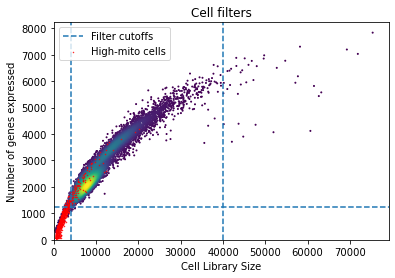

In [12]:
#Plot all filtering metrics together
from scipy.stats import gaussian_kde
x = scRNA_counts.obs.total_counts
y = scRNA_counts.obs.n_genes_by_counts

x_mit = scRNA_counts_mitocut.obs.total_counts
y_mit = scRNA_counts_mitocut.obs.n_genes_by_counts

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=1)
ax.scatter(x_mit, y_mit, c='red', s=0.2, label='High-mito cells')
plt.title('Cell filters')
plt.xlabel('Cell Library Size')
plt.ylabel('Number of genes expressed')
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.axvline(x=4000, ymin=0, ymax=1,linestyle='--')
plt.axvline(x=40000, ymin=0, ymax=1,linestyle='--')
plt.axhline(y=1250, xmin=0, xmax=1,linestyle='--', label='Filter cutoffs')
plt.legend(loc='upper left')
plt.savefig('/home/jbs/scRNA-seq/steps/redone/Figures/filter_recap.svg', format='svg') 
plt.show()

In [ ]:

#Filter cells based on library size
sc.pp.filter_cells(scRNA_counts, min_counts=4000) 
sc.pp.filter_cells(scRNA_counts, max_counts=40000) 

#Filter cells based on genes expressed
sc.pp.filter_cells(scRNA_counts, min_genes=1250)
#sc.pp.filter_cells(scRNA_counts, max_genes=3000)

#Filter genes based on cells expressing them
sc.pp.filter_genes(scRNA_counts, min_cells=10)



In [14]:
#Copy raw counts before preprocessing them
scRNA_counts.layers["counts"] = scRNA_counts.X.copy().toarray();

## Selecting highly variable genes

Finally we select n-number of the most variable genes in data using scanpy. This magnifies the signal in the dataset and furthermore the more variable genes are the ones we are interested in.

Trying to set attribute `.obs` of view, copying.


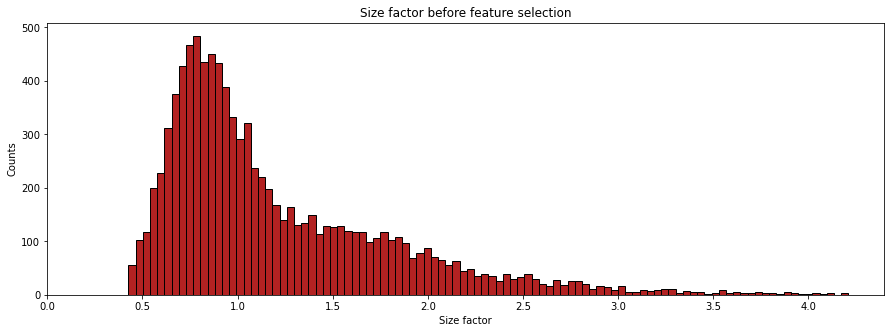

In [18]:
%matplotlib inline
scRNA_counts.obs['size_factors'] = (scRNA_counts.obs.n_counts/np.median(scRNA_counts.obs.n_counts)).to_numpy()
sc.pp.normalize_total(scRNA_counts)
sc.pp.log1p(scRNA_counts)

plt.figure(figsize = (15,5))
nu.plot_histo_filter(scRNA_counts.obs['size_factors'],
                  title='Size factor before feature selection',
                  xlab='Size factor',
                  ylab='Counts',
                  bins=100,
                  ylog=False); #xwin sets the range of x for making the hist

#n_top selects the n_top_genes variable genes
sc.pp.highly_variable_genes(scRNA_counts,
                           n_top_genes=1000)

#Extract names of the highly variable genes
variable_genes = scRNA_counts.var["highly_variable"]
scRNA_counts = scRNA_counts[:, variable_genes]

sc.pp.calculate_qc_metrics(scRNA_counts, 
                           percent_top=None,
                           inplace=True,
                           layer='counts',
                           log1p=True);

**Finally Z-score normalize the counts**

In [176]:
sc.pp.scale(scRNA_counts, max_value=10, zero_center=True)

## Create tss-fasta from annotation file

If using a sequence dependent model we need to extract the proper sequences to use. Below cell does this using the final genes of the dataset.

In [ ]:
scRNA_geneid = scRNA_counts.var_names.to_list()
window_size=600
final_geneid = nu.fetch_tss_to_fasta(seq_window_size=window_size,
                               scRNA_geneid_list=scRNA_geneid,
                               ann_path='/home/jbs/scRNA-seq/data/annotation_2kbp.tss',
                               genome_path='/home/jbs/scRNA-seq/data/GRCh38.primary_assembly.genome.fa',
                               out_path=f'/home/jbs/scRNA-seq/steps/preprocessed/redone/seq_win{window_size}.fa')






In [ ]:
#Remove unused metrics
discard_metrics={
'obs':['total_counts','n_genes_by_counts','n_counts', 'n_genes', 'total_counts_mt',
       'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts'],
'var':['n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts',
      'n_cells','highly_variable','means','dispersions','dispersions_norm',
      'log1p_mean_counts','log1p_total_counts','mean','std','mt']
}
for metric in discard_metrics['obs']:
    del scRNA_counts.obs[metric]
for metric in discard_metrics['var']:
    del scRNA_counts.var[metric]
scRNA_counts


In [ ]:
#Finally drop genes from count_data not present in sequence, and save
scRNA_counts=scRNA_counts[:, final_geneid]
scRNA_counts.write(f'/home/jbs/scRNA-seq/steps/preprocessed/redone/PBMC_win{window_size}.h5',as_dense='X')

###sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

## Dropout/downsample datasets

In [45]:
scRNA_test = scRNA_counts.copy()

In [ ]:

def downsample(count_matrix, fraction):
    #Define metrics to track
    count_matrix = count_matrix.astype(int)
    ds_count_matrix = np.zeros(count_matrix.shape)
    n_newzero = []
    m_newzero = []
    
    #Generator used for sampling
    gen = np.random.Generator(np.random.PCG64(42))
    for n in range(count_matrix.shape[0]):
        #Downsample cell to counts equal to fraction
        target_count = int(np.floor(np.sum(count_matrix[n,:])*fraction))
        
        #Downsample to target counts
        ds_count_matrix[n,:] = gen.multivariate_hypergeometric(count_matrix[n,:], target_count)
        ds_count_matrix = ds_count_matrix.astype(int)
        
        #Track counts that dropput
        new_zero = np.setdiff1d(np.nonzero(ds_count_matrix[n,:]==0)[0], np.nonzero(count_matrix[n,:]==0)[0])
        m_newzero.extend(new_zero)
        n_newzero.extend([n]*len(new_zero))
        
    dropout_idx = list(zip(n_newzero, m_newzero))
    
    return ds_count_matrix, dropout_idx




In [ ]:
#Create corrupted datasets for different downsample fractions
for downsample_fraction in [0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    scRNA_ds = scRNA_counts.copy()
    #Downsample
    scRNA_ds.layers['counts'], scRNA_ds.uns['dropout_idx'] = downsample(scRNA_ds.layers['counts'], downsample_fraction)
    scRNA_ds.layers['counts']/downsample_fraction
    scRNA_ds.uns['Downsample_fraction'] = downsample_fraction

    #normalize, log- and z-scale
    scRNA_ds.X = scRNA_ds.layers['counts'].copy()
    sc.pp.normalize_total(scRNA_ds)
    sc.pp.log1p(scRNA_ds)
    sc.pp.scale(scRNA_ds, max_value=10, zero_center=True)
    
    #Save dataset
    scRNA_ds.write(f'/home/jbs/scRNA-seq/steps/preprocessed/redone/PBMC_ds{downsample_fraction}.h5',as_dense='X')